In [266]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np

#import F
from torch.nn import functional as F

In [267]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [268]:
image_transform = transforms.Compose([
    transforms.Resize((128,128)),transforms.ToTensor(),transforms.Lambda(lambda x : x.to(device))
])

In [269]:
from torchvision import datasets


In [270]:
trainFolder = 'train'
trainDataset = datasets.ImageFolder(trainFolder, transform=image_transform)

# Select 1000 images only to train
#trainDataset = torch.utils.data.Subset(trainDataset, np.random.choice(len(trainDataset), 1000, replace=False))

validFolder = 'val'
validDataset = datasets.ImageFolder(validFolder, transform=image_transform)

# Select 100 images only to validate
#validDataset = torch.utils.data.Subset(validDataset, np.random.choice(len(validDataset), 100, replace=False))

In [271]:
print('Train dataset:', len(trainDataset))
print('Valid dataset:', len(validDataset))

Train dataset: 5153
Valid dataset: 500


In [272]:
#Import DataLoader
from torch.utils.data import DataLoader
batchSize = 32
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=True) 

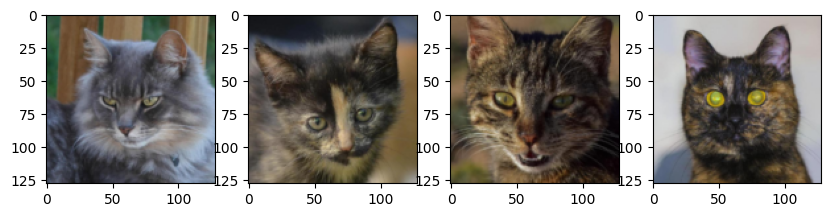

In [273]:
# print some images from the trainLoader
import matplotlib.pyplot as plt
import numpy as np
for images, labels in trainLoader:
    fig, axes = plt.subplots(figsize=(10,4), ncols=4)
    for i in range(4):
        ax = axes[i]
        ax.imshow(images[i].cpu().numpy().transpose(1,2,0).squeeze())
    break

In [274]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, in_channels: int, LatentDimension: int):
        super(VariationalAutoEncoder, self).__init__()
        self.LatentDimension = LatentDimension
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )
        
        # mean and log variance
        self.mean = nn.Linear(512*4*4, LatentDimension)
        self.logvar = nn.Linear(512*4*4, LatentDimension)
        
        # Build Decoder
        self.decoderInput = nn.Linear(LatentDimension, 512*4*4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
        
    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        
        mean = self.mean(result)
        logVar = self.logvar(result)
        
        return [mean, logVar]
    
    def decode(self, input):
        result = self.decoderInput(input)
        result = result.view(-1, 512, 4, 4)
        result = self.decoder(result)
        return result
    

    def reparametrize(self, mean, logVar):
        std = torch.exp(0.5*logVar)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def forward(self, input):
        mean, logVar = self.encode(input)
        z = self.reparametrize(mean, logVar)
        return [self.decode(z), input, mean, logVar]
    
    def lossFunction(self, x_hat, x, mean, logVar):
        # Reconstruction loss
        reconsLoss = F.mse_loss(x_hat, x, reduction='sum')
        
        # KL Divergence Loss
        KLdivergence = -0.5 * torch.sum(1 + logVar - mean.pow(2) - logVar.exp())
        KLDweight = 0.001      
        loss = reconsLoss + KLDweight * KLdivergence
        return {'loss': loss, 'Reconstruction_Loss': reconsLoss.detach(), 'KL_Divergence': KLdivergence.detach()}
    
    def sample(self, numSamples):
        z = torch.randn(numSamples, self.LatentDimension).to(device)
        return self.decode(z)
    
    def generate(self, x):
        return self.forward(x)[0]

In [275]:
# Create the model
model = VariationalAutoEncoder(in_channels=3, LatentDimension=128).to(device)

In [276]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [277]:
# training Loop
numEpochs = 80

for epoch in range(numEpochs):
    model.train()
    for batch_idx, (data, _) in enumerate(trainLoader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        losses = model.lossFunction(*output)
        losses["loss"].backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tReconstruction Loss: {:.6f}\tKL Divergence: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainLoader.dataset),
                100. * batch_idx / len(trainLoader), losses['loss'].item(), losses['Reconstruction_Loss'].item(), losses['KL_Divergence'].item()))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(validLoader):
            data = data.to(device)
            output = model(data)
            losses = model.lossFunction(*output)
            valid_loss += losses['loss'].item()
            
        # plot the reconstructed images(generate one)
        for image,label in validLoader:
            image = image.to(device)
            N=6
            fig,axes=plt.subplots(2,N,figsize=(20,5))
            #plot the original images
            for i in range(N):
                axes[0,i].imshow(image[i].cpu().numpy().transpose(1,2,0).squeeze())
                axes[0,i].axis('off')
                
            #plot the reconstructed images
            recons=model.generate(image)
            for i in range(N):
                axes[1,i].imshow(recons[i].cpu().detach().numpy().transpose(1,2,0).squeeze())
                axes[1,i].axis('off')
                
            break
        #save the plot
        plt.savefig('reconstructed_images.png')
        
        # remove previous plot
        plt.clf()
        
        # sample from the model
        sample = model.sample(100)
        fig, axes = plt.subplots(10, 10, figsize=(20, 20))
        for i in range(10):
            for j in range(10):
                axes[i, j].imshow(sample[i*10+j].cpu().detach().numpy().transpose(1,2,0).squeeze())
                axes[i, j].axis('off')
                
    
            
        #save the plot
        plt.savefig('sampled_images.png')
        
        # remove previous plot
        plt.clf()
                
        valid_loss /= len(validLoader.dataset)
        print('====> Valid set loss: {:.4f}'.format(valid_loss))

Train Epoch: 0 [0/5153 (0%)]	Loss: 813017.000000	Reconstruction Loss: 813016.500000	KL Divergence: 515.630005


Train Epoch: 0 [3200/5153 (62%)]	Loss: 68413.554688	Reconstruction Loss: 68211.039062	KL Divergence: 202513.593750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 1613.5439
Train Epoch: 1 [0/5153 (0%)]	Loss: 54737.917969	Reconstruction Loss: 54608.960938	KL Divergence: 128955.312500
Train Epoch: 1 [3200/5153 (62%)]	Loss: 45869.777344	Reconstruction Loss: 45778.554688	KL Divergence: 91224.375000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 13591.3309
Train Epoch: 2 [0/5153 (0%)]	Loss: 1154541.250000	Reconstruction Loss: 183730.609375	KL Divergence: 970810560.000000
Train Epoch: 2 [3200/5153 (62%)]	Loss: 40418.207031	Reconstruction Loss: 40350.406250	KL Divergence: 67799.421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 1195.5890
Train Epoch: 3 [0/5153 (0%)]	Loss: 37030.855469	Reconstruction Loss: 36957.851562	KL Divergence: 73004.523438
Train Epoch: 3 [3200/5153 (62%)]	Loss: 33951.964844	Reconstruction Loss: 33872.113281	KL Divergence: 79851.265625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 1063.5863
Train Epoch: 4 [0/5153 (0%)]	Loss: 36762.230469	Reconstruction Loss: 36679.109375	KL Divergence: 83122.093750
Train Epoch: 4 [3200/5153 (62%)]	Loss: 32518.449219	Reconstruction Loss: 32442.986328	KL Divergence: 75463.523438
====> Valid set loss: 969.4329
Train Epoch: 5 [0/5153 (0%)]	Loss: 34267.156250	Reconstruction Loss: 34186.953125	KL Divergence: 80203.875000
Train Epoch: 5 [3200/5153 (62%)]	Loss: 30702.048828	Reconstruction Loss: 30623.191406	KL Divergence: 78858.375000
====> Valid set loss: 923.8700
Train Epoch: 6 [0/5153 (0%)]	Loss: 31001.748047	Reconstruction Loss: 30921.130859	KL Divergence: 80617.296875
Train Epoch: 6 [3200/5153 (62%)]	Loss: 28728.976562	Reconstruction Loss: 28648.119141	KL Divergence: 80857.359375
====> Valid set loss: 892.7237
Train Epoch: 7 [0/5153 (0%)]	Loss: 30491.994141	Reconstruction Loss: 30407.900391	KL Divergence: 84094.500000
Train Epoch: 7 [3200/5153 (62%)]	Loss: 28299.125000	Reconstruction Loss: 28218.548828	KL Dive

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 840.1469
Train Epoch: 8 [0/5153 (0%)]	Loss: 25091.400391	Reconstruction Loss: 25004.335938	KL Divergence: 87065.109375
Train Epoch: 8 [3200/5153 (62%)]	Loss: 26809.904297	Reconstruction Loss: 26721.738281	KL Divergence: 88166.585938


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 828.4422
Train Epoch: 9 [0/5153 (0%)]	Loss: 29892.822266	Reconstruction Loss: 29808.753906	KL Divergence: 84068.242188
Train Epoch: 9 [3200/5153 (62%)]	Loss: 23088.474609	Reconstruction Loss: 23000.939453	KL Divergence: 87534.507812


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 773.2483
Train Epoch: 10 [0/5153 (0%)]	Loss: 24703.541016	Reconstruction Loss: 24609.632812	KL Divergence: 93907.765625
Train Epoch: 10 [3200/5153 (62%)]	Loss: 21943.873047	Reconstruction Loss: 21856.033203	KL Divergence: 87840.703125


/tmp/ipykernel_544199/1422097703.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axes=plt.subplots(2,N,figsize=(20,5))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 738.2613
Train Epoch: 11 [0/5153 (0%)]	Loss: 21269.626953	Reconstruction Loss: 21180.710938	KL Divergence: 88915.640625
Train Epoch: 11 [3200/5153 (62%)]	Loss: 24827.261719	Reconstruction Loss: 24734.900391	KL Divergence: 92362.054688


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 689.7653
Train Epoch: 12 [0/5153 (0%)]	Loss: 21732.281250	Reconstruction Loss: 21645.470703	KL Divergence: 86810.515625
Train Epoch: 12 [3200/5153 (62%)]	Loss: 26394.455078	Reconstruction Loss: 26297.671875	KL Divergence: 96782.445312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 682.1780
Train Epoch: 13 [0/5153 (0%)]	Loss: 22636.210938	Reconstruction Loss: 22543.048828	KL Divergence: 93162.304688
Train Epoch: 13 [3200/5153 (62%)]	Loss: 22086.173828	Reconstruction Loss: 21992.843750	KL Divergence: 93330.343750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 666.4319
Train Epoch: 14 [0/5153 (0%)]	Loss: 21939.363281	Reconstruction Loss: 21842.875000	KL Divergence: 96489.085938
Train Epoch: 14 [3200/5153 (62%)]	Loss: 24879.236328	Reconstruction Loss: 24784.244141	KL Divergence: 94993.109375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 650.3492
Train Epoch: 15 [0/5153 (0%)]	Loss: 19202.417969	Reconstruction Loss: 19106.468750	KL Divergence: 95949.859375
Train Epoch: 15 [3200/5153 (62%)]	Loss: 20606.322266	Reconstruction Loss: 20503.644531	KL Divergence: 102677.195312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 665.6272
Train Epoch: 16 [0/5153 (0%)]	Loss: 20765.087891	Reconstruction Loss: 20665.542969	KL Divergence: 99545.281250
Train Epoch: 16 [3200/5153 (62%)]	Loss: 18734.150391	Reconstruction Loss: 18634.607422	KL Divergence: 99542.218750


KeyboardInterrupt: 

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

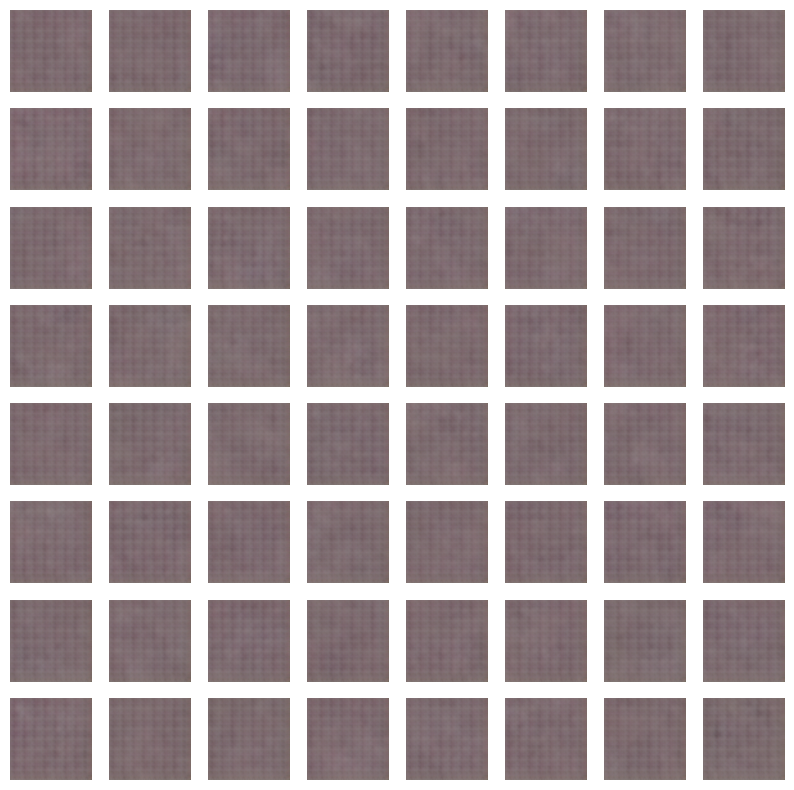

In [ ]:
# sample new 64 images in 8x8 grid
N = 64
samples = model.sample(N)
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(samples[i*8+j].cpu().detach().numpy().transpose(1,2,0).squeeze())
        axes[i, j].axis('off')
plt.savefig('generated_images.png')
